In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
    <td>
      <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/analytics-componentized-patterns/master/retail/time-series/bqml-demand-forecasting/bqml_retail_demand_forecasting.ipynb">
        <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI Workbench">Run on Vertex AI Workbench</a>
    </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/tree/master/retail/time-series/bqml-demand-forecasting/">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Building a demand forecasting model by using BigQuery ML

This notebook shows you how to train, deploy, and evaluate a time series model by using BigQuery ML. It provides an end-to-end solution for forecasting multiple products. Using the public [Iowa Liquor Sales data](https://console.cloud.google.com/marketplace/details/obfuscated-ga360-data/obfuscated-ga360-data?filter=solution-type:dataset) dataset, you use a single SQL query to create five time series models, where each model forecasts the retail sales of a single liquor product. 

By the end of this notebook, you will know how to:
* Pre-process time series data into the correct format needed to create the model.
* Train the time series model in BigQuery ML.
* Evaluate the model.
* Make predictions about future demand using the model.
* Create a dashboard to visualize the forecasted demand using Data Studio.

## Setup

Install the required packages, configure the environment variables, and create a BigQuery dataset.

### PIP Install Packages and dependencies

In [ ]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

In [2]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

{'status': 'ok', 'restart': True}

### Configure GCP environment settings

Update the following variables to reflect the values for your GCP environment:

* PROJECT_ID: The ID of the Google Cloud project you are using to implement this solution.
* REGION: The region to use for the BigQuery dataset.

In [1]:
PROJECT_ID = 'YOUR-PROJECT-ID' # Change to your project.
REGION = 'US'

### Import libraries and define constants

In [2]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Import libraries for data manipulation and plotting

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, 
                                 timestamp_col_name, 
                                 data_col_name, 
                                 forecast_output=None, 
                                 actual=None, 
                                 title=None,
                                 plotstartdate=None):

    if plotstartdate:
        input_timeseries[timestamp_col_name] = pd.to_datetime(input_timeseries[timestamp_col_name])
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]
        
    input_timeseries = input_timeseries.sort_values(timestamp_col_name)    
    
    # Plot the input historical data
    plt.figure(figsize=(20,6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

    # Display title, legend
    plt.title(f'{title}', fontsize= 16)
    plt.legend(loc = 'upper center', prop={'size': 16})

### Create a BigQuery dataset

Create a dataset in your project called `bqmlforecast`:

In [4]:
!bq mk --location=$REGION --dataset $PROJECT_ID:bqmlforecast

BigQuery error in mk operation: Dataset 'polong-bigquery:bqmlforecast' already
exists.


## Prepare the training data

You train the time series models on a dataset containing transactional data. Each row represents a transaction on a single product, as identified by the `item_description` value, and contains details such as the number of bottles sold and the sales amount in dollars. In following steps, you use the number of bottles sold value to forecast product demand.

_Note_: Jupyter runs cells starting with %%bigquery as SQL queries

In [5]:
%%bigquery --project $PROJECT_ID

SELECT 
    invoice_and_item_number,
    date,
    store_number,
    item_description,
    bottles_sold,
    sale_dollars
FROM
  `bigquery-public-data.iowa_liquor_sales.sales` 
LIMIT 
  5

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_and_item_number,date,store_number,item_description,bottles_sold,sale_dollars
0,INV-22973000026,2019-11-01,5239,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.400
1,INV-26366100059,2020-04-07,3993,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.400
2,INV-38829900045,2021-07-30,4551,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.400
3,INV-24506900005,2020-01-13,5211,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.400
4,INV-14129500095,2018-08-29,2536,JAGERMEISTER MINI MEISTERS,1,7.400


### [Optional] Transform your data to the expected schema

If you use the sample dataset, you can skip this step.

If you want to use your own data, import your sales data to BigQuery, and then adapt the following SQL query to create a view with the appropriate schema. Update `[YOUR_PROJECT].[YOUR_DATASET].[YOUR_SOURCE_TABLE]` to reflect the project, dataset, and table containing your sales data.

In [6]:
# %%bigquery --project $PROJECT_ID

# CREATE OR REPLACE VIEW bqmlforecast.training_data AS (
# SELECT
#   date,
#   item_name,
#   total_amount_sold
# FROM
#   `[YOUR_PROJECT].[YOUR_DATASET].[YOUR_SOURCE_TABLE]`
# );

### Set the start and end dates for the training data

You can adjust the `TRAININGDATA_STARTDATE` and `TRAININGDATA_ENDDATE` parameters to specify the start/end dates of your training data:

In [7]:
ARIMA_PARAMS = {
    'TRAININGDATA_STARTDATE': '2016-01-01',
    'TRAININGDATA_ENDDATE': '2017-06-01',
}
ARIMA_PARAMS

{'TRAININGDATA_STARTDATE': '2016-01-01', 'TRAININGDATA_ENDDATE': '2017-06-01'}

### Write the training data to a table

If you review the training data, you can observe that some days have no transactions for a given product. To keep you from having to do additional pre-processing, BigQuery ML automatically handles the following situations:

* Missing values: Values are imputed using local [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation).
* Duplicated timestamps: Values are averaged across duplicated timestamps.
* Spike and dip anomalies: Values are standardized using local [z-scores](https://en.wikipedia.org/wiki/Standard_score).

In [8]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE TABLE bqmlforecast.training_data AS (
    WITH topsellingitems AS(
         SELECT 
            item_description,
            count(item_description) cnt_transactions
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales` 
        GROUP BY 
            item_description
        ORDER BY cnt_transactions DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales` 
    GROUP BY
        date, item_name
    HAVING 
        date BETWEEN @TRAININGDATA_STARTDATE AND @TRAININGDATA_ENDDATE
        AND item_description IN (SELECT item_description FROM topsellingitems)
    );

SELECT 
    date,
    item_name,
    total_amount_sold
FROM 
    bqmlforecast.training_data 
ORDER BY item_name, date
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,date,item_name,total_amount_sold
0,2016-01-04,BLACK VELVET,5014
1,2016-01-05,BLACK VELVET,5193
2,2016-01-06,BLACK VELVET,4422
3,2016-01-07,BLACK VELVET,3760
4,2016-01-11,BLACK VELVET,4492
5,2016-01-12,BLACK VELVET,4945
6,2016-01-13,BLACK VELVET,4302
7,2016-01-14,BLACK VELVET,3394
8,2016-01-15,BLACK VELVET,2318
9,2016-01-19,BLACK VELVET,4714


### Plot the sales histories of the target liquor products

Save the training data to the `dfhistorical` Pandas dataframe:

In [9]:
%%bigquery dfhistorical --project $PROJECT_ID 

SELECT 
    * 
FROM 
    bqmlforecast.training_data

Query is running:   0%|          |

Downloading:   0%|          |

Using the training data, plot the sales histories of the target liquor products:

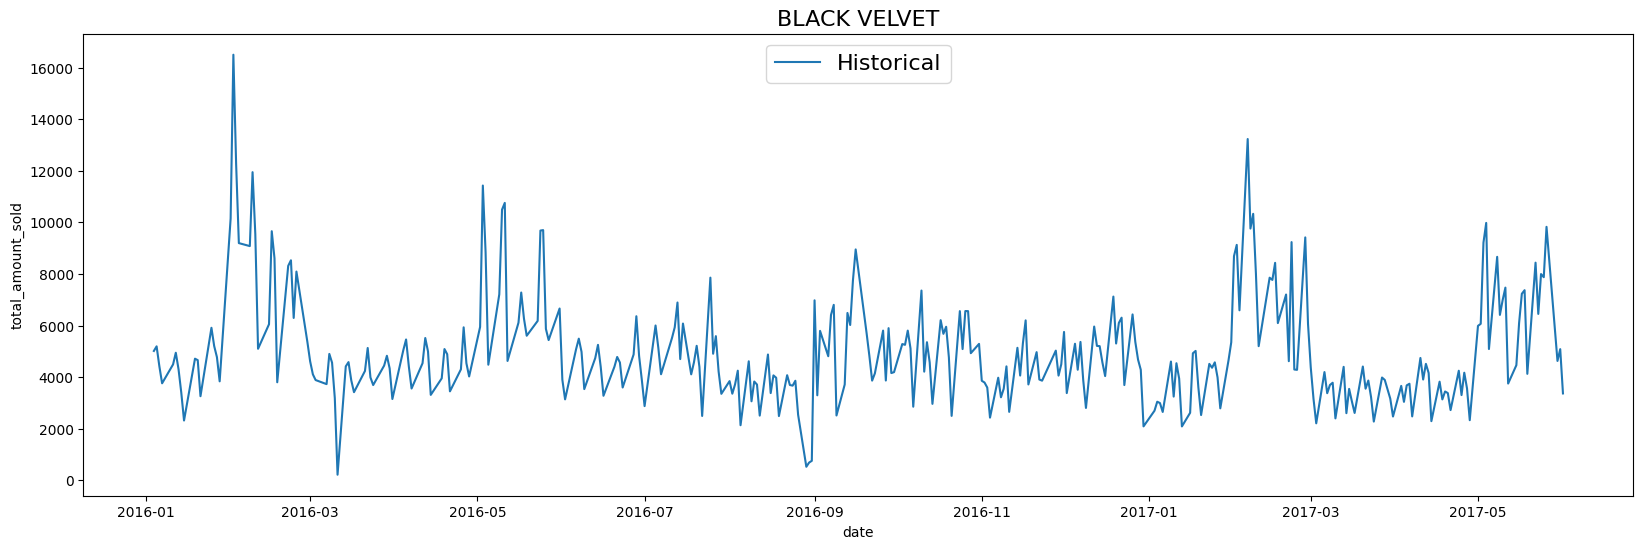

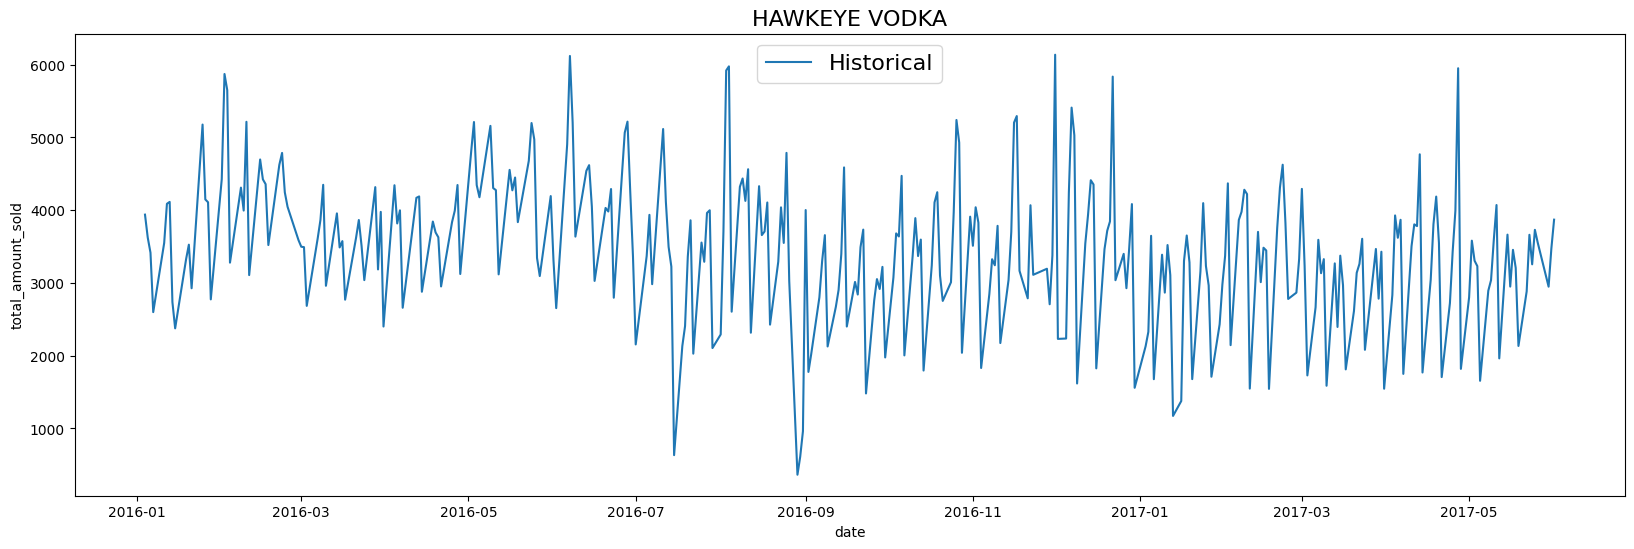

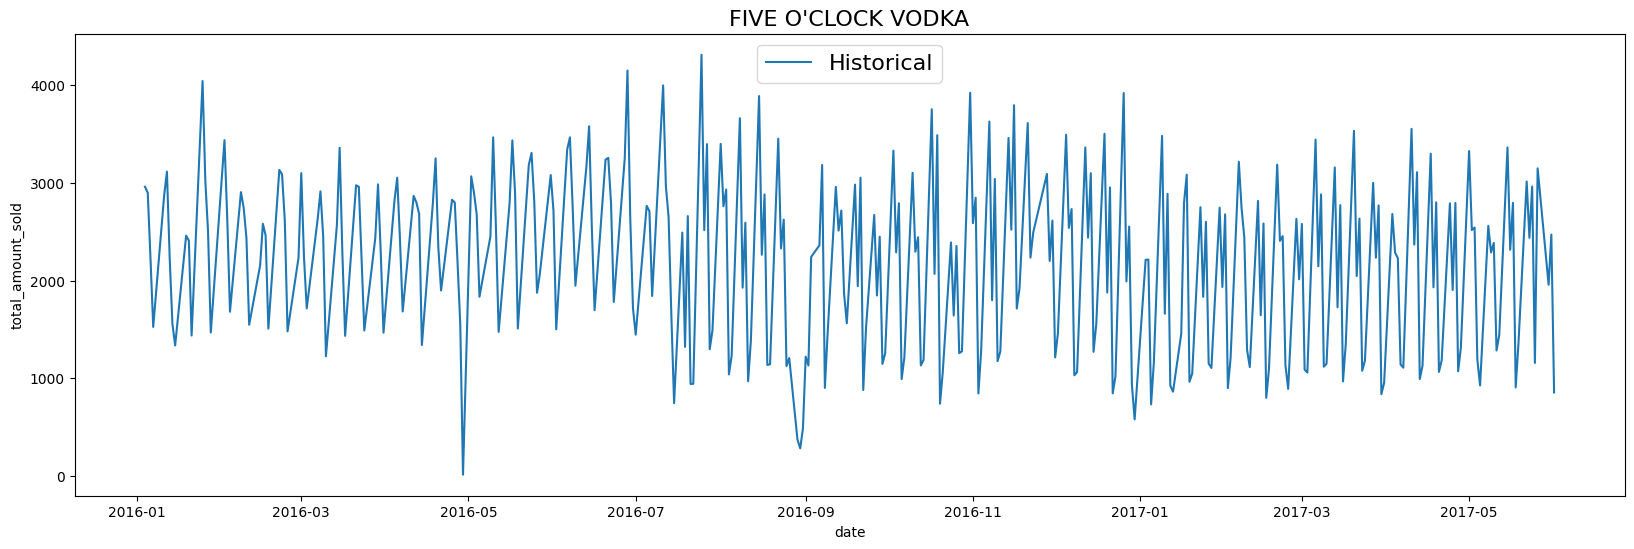

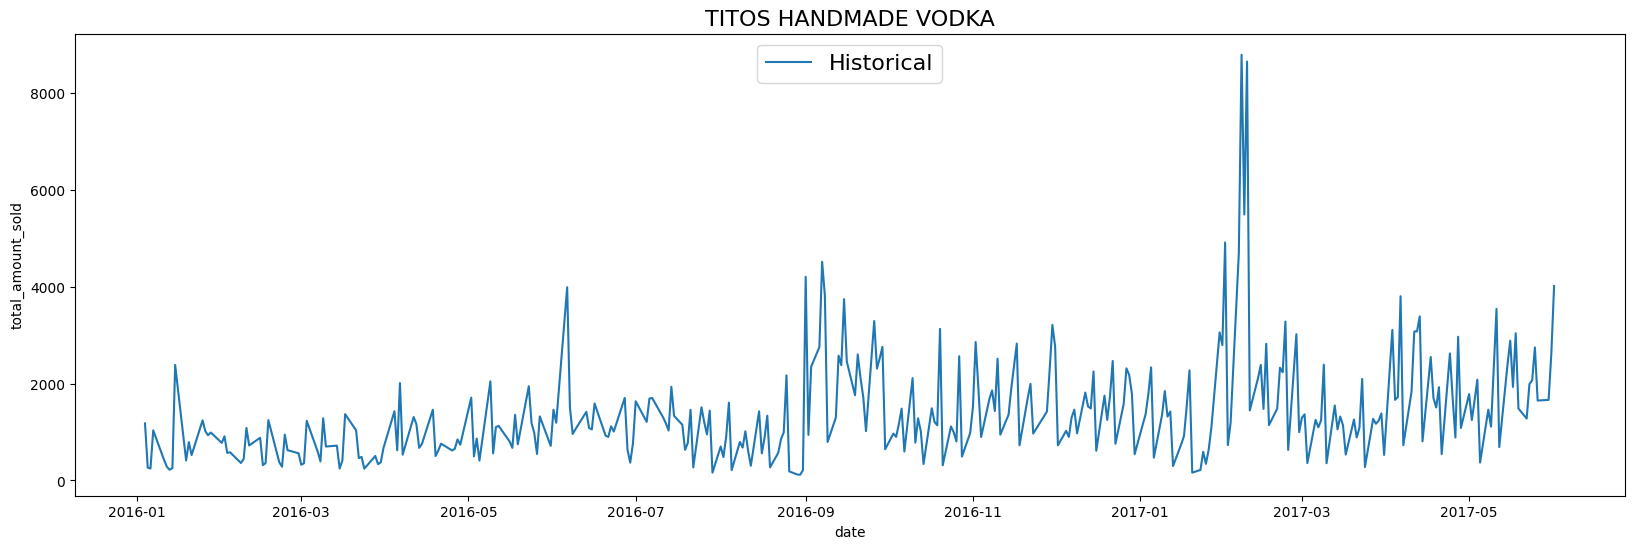

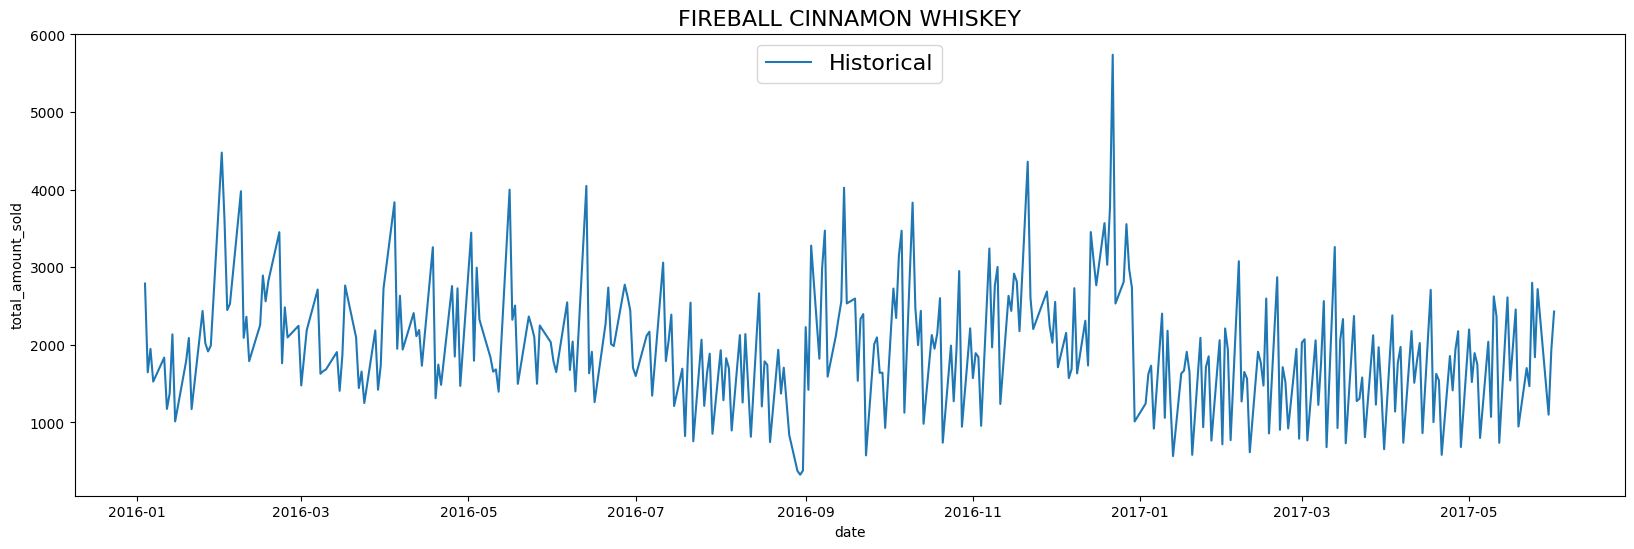

In [10]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    
    datah = dfhistorical[dfhistorical.item_name==item]
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = None, 
                                 actual = None,
                                 title = item)

## Train the model

Because you are training the model on multiple products in a single model creation statement, you must specify the `item_name` column for the [TIME_SERIES_ID_COL](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#time_series_id_col) parameter. If you were only forecasting a single item, then you would not need to specify `TIME_SERIES_ID_COL`. For more information, see the [BigQuery ML time series model creation documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#create_model_syntax).

You can also account for holiday effects when doing time series modeling in BigQuery ML. By default, holiday effects modeling is disabled. But since this data is from the United States, and the data includes a minimum one year of daily data, you can also specify an optional `HOLIDAY_REGION`. With holiday effects enabled, spikes and dips that appear during holidays will no longer be treated as anomalies. A full list of the holiday regions can be found in the [HOLIDAY_REGION documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#holiday_region).



In [11]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE MODEL bqmlforecast.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL='item_name',
  HOLIDAY_REGION='US'
) AS

SELECT 
    date,
    item_name,
    total_amount_sold
FROM
  bqmlforecast.training_data

Query is running:   0%|          |

""


### Evaluate the model

Use the [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) function to see the evaluation metrics of all the created models. 

The `non_seasonal_`{`p`,`d`,`q`} and `has_drift` columns define the time series model. The `log_likelihood`, `AIC`, and `variance` columns are relevant to the model fitting process. The fitting process determines the best model by using the [auto.ARIMA algorithm](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#auto_arima), one for each time series.

In [12]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlforecast.arima_model)

Query is running:   0%|          |

Downloading:   0%|          |

,item_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,BLACK VELVET,3,1,2,False,-4132.346,8276.691,562466.115,[WEEKLY]
1,FIREBALL CINNAMON WHISKEY,2,1,1,True,-3683.019,7376.037,97168.305,[WEEKLY]
2,FIVE O'CLOCK VODKA,4,0,1,False,-3491.474,6996.948,8757.842,[WEEKLY]
3,HAWKEYE VODKA,2,1,2,False,-3785.002,7580.004,145425.326,[WEEKLY]
4,TITOS HANDMADE VODKA,0,1,5,False,-3807.245,7626.489,157343.325,[WEEKLY]


You can see that five models were trained, one for each of the products in the `item_name` column. Each model has its own `p,d,q` hyperparameters, and the detected seasonality for these five models is `WEEKLY`.

## Make predictions using the model

Make predictions using [ML.FORECAST](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast), which forecasts the next _n_ values, as specified in the `horizon` parameter. You can also optionally change the `confidence_level` parameter to change the percentage of future values that fall in the prediction interval. You save the prediction data to the `dfforecast` dataframe so that you can plot it in a following step.


In [13]:
%%bigquery dfforecast --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL bqmlforecast.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)

Query is running:   0%|          |

Downloading:   0%|          |

In [14]:
dfforecast.head()

,item_name,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,BLACK VELVET,2017-06-02 00:00:00+00:00,1404.775,749.977,0.900,172.509,2637.042,172.509,2637.042
1,BLACK VELVET,2017-06-03 00:00:00+00:00,2013.170,971.562,0.900,416.824,3609.516,416.824,3609.516
2,BLACK VELVET,2017-06-04 00:00:00+00:00,3213.622,1177.028,0.900,1279.681,5147.562,1279.681,5147.562
3,BLACK VELVET,2017-06-05 00:00:00+00:00,3573.866,1281.806,0.900,1467.767,5679.964,1467.767,5679.964
4,BLACK VELVET,2017-06-06 00:00:00+00:00,2257.318,1391.810,0.900,-29.524,4544.161,-29.524,4544.161


Since `horizon` is set to 30, the result is 30 x (number of items), with one row per forecasted value:

In [15]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 150


#### Inspect the model coefficients

You can view the coefficients of each of the time series models using [ML.ARIMA_COEFFICIENTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients).

For each of the models, the `ar_coefficients` value shows the model coefficients of the autoregressive (AR) part of the time series model. Similarly, the `ma_coefficients` value shows the model coefficients of the moving-average (MA) part of the model. Both of these values are arrays, and their lengths are equal to `non_seasonal_p` and `non_seasonal_q`, respectively. The `intercept_or_drift` value is the constant term in the time series model.

In [30]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL bqmlforecast.arima_model)

Query is running:   0%|          |

Downloading:   0%|          |

,item_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,BLACK VELVET,"[-0.16549655445723319, -0.7477843111888047, -0...","[-0.010971872002911037, 0.7809755718652553]",0.000
1,FIREBALL CINNAMON WHISKEY,"[0.5099256868357989, 0.17365890632425174]",[-0.9999915981003452],-2.764
2,FIVE O'CLOCK VODKA,"[-0.3596844148293946, 0.6178849330746929, 0.15...",[0.8837349172639454],2129.972
3,HAWKEYE VODKA,"[-0.20942045212532412, 0.6765204517126348]","[-0.08520133108699894, -0.8556243195314104]",0.000
4,TITOS HANDMADE VODKA,[],"[-0.2597486052415876, 0.1442453510061992, -0.5...",0.000


#### Plot the forecasted predictions against the historical data

Plot the forecasted predictions, using the `dfhistorical` dataframe that contains the historical data that you used for training and the `dfforecast` dataframe that contains the prediction data:

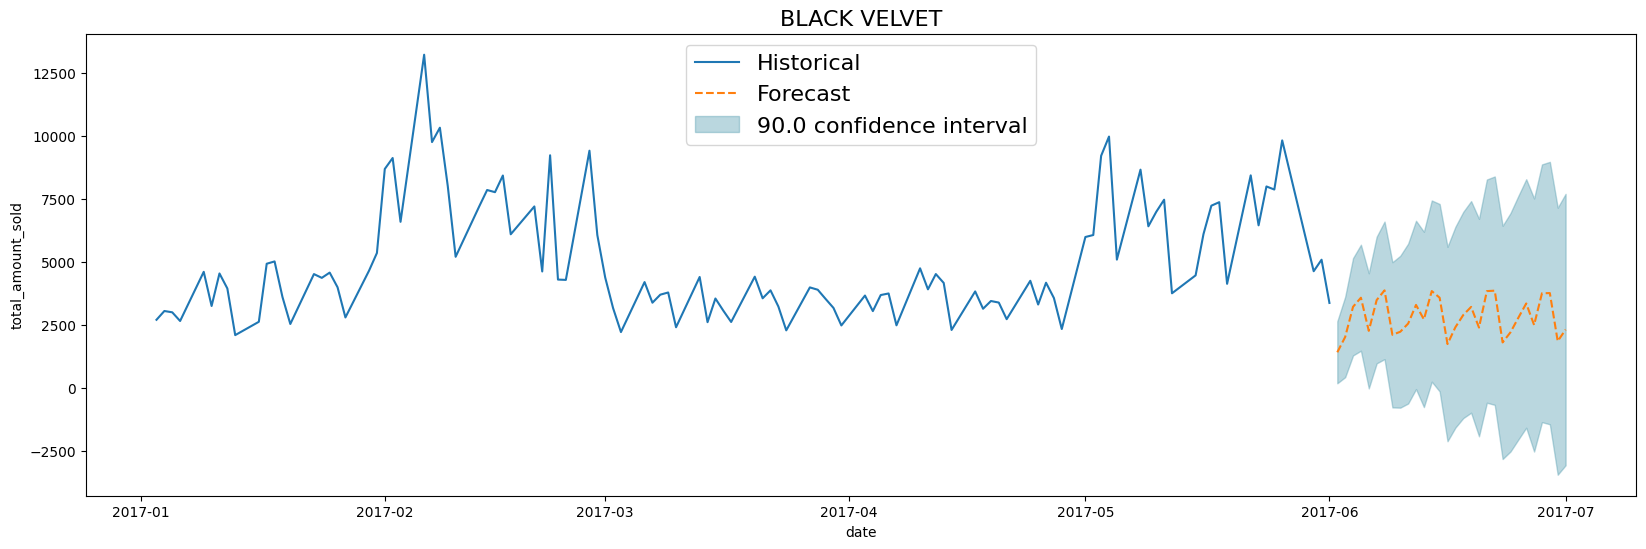

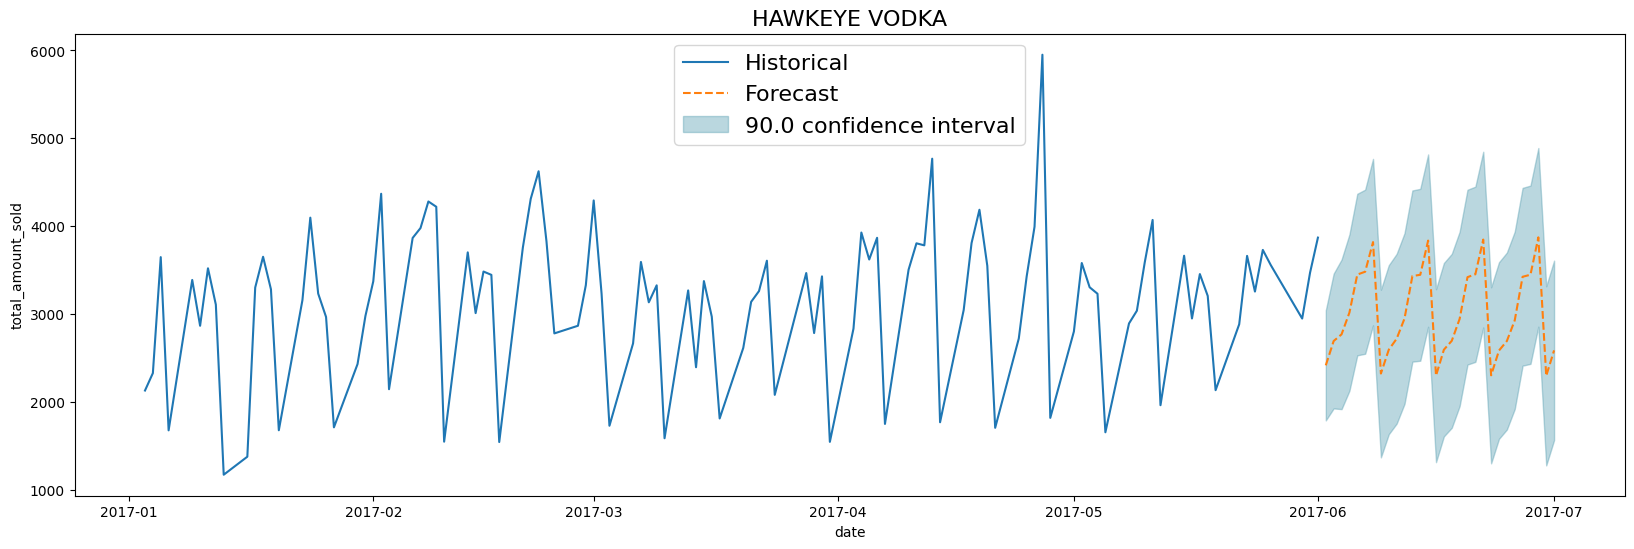

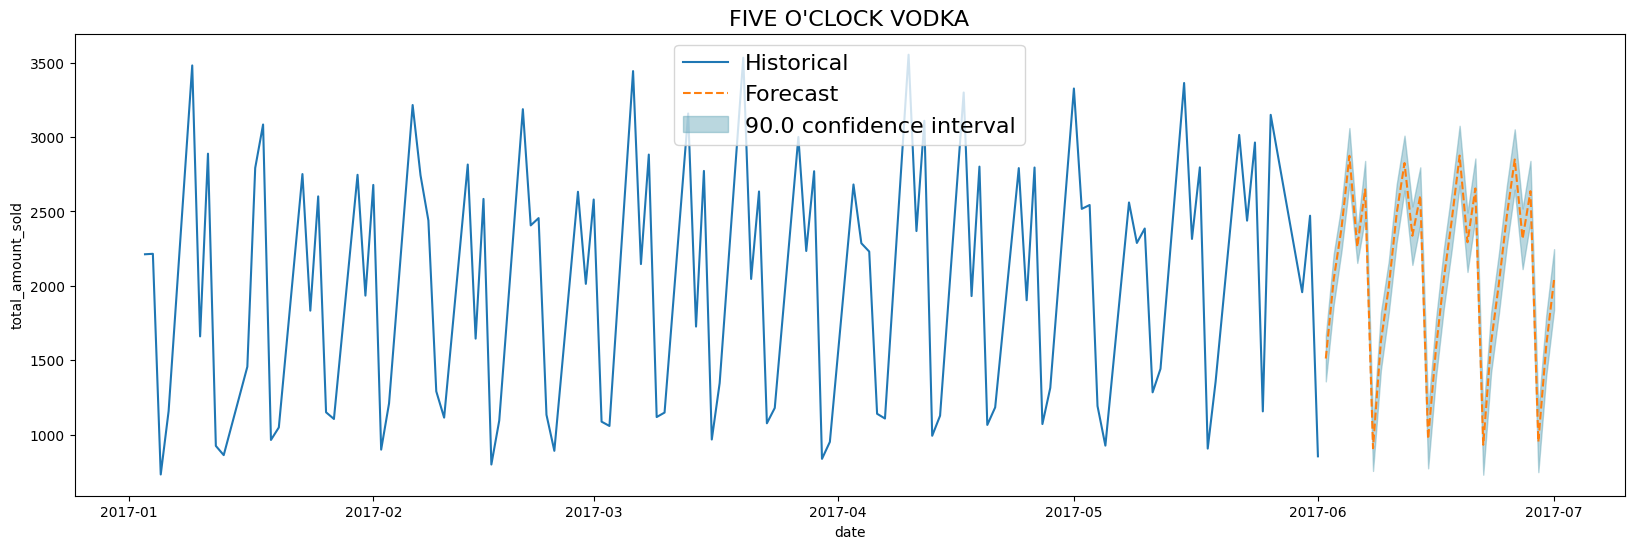

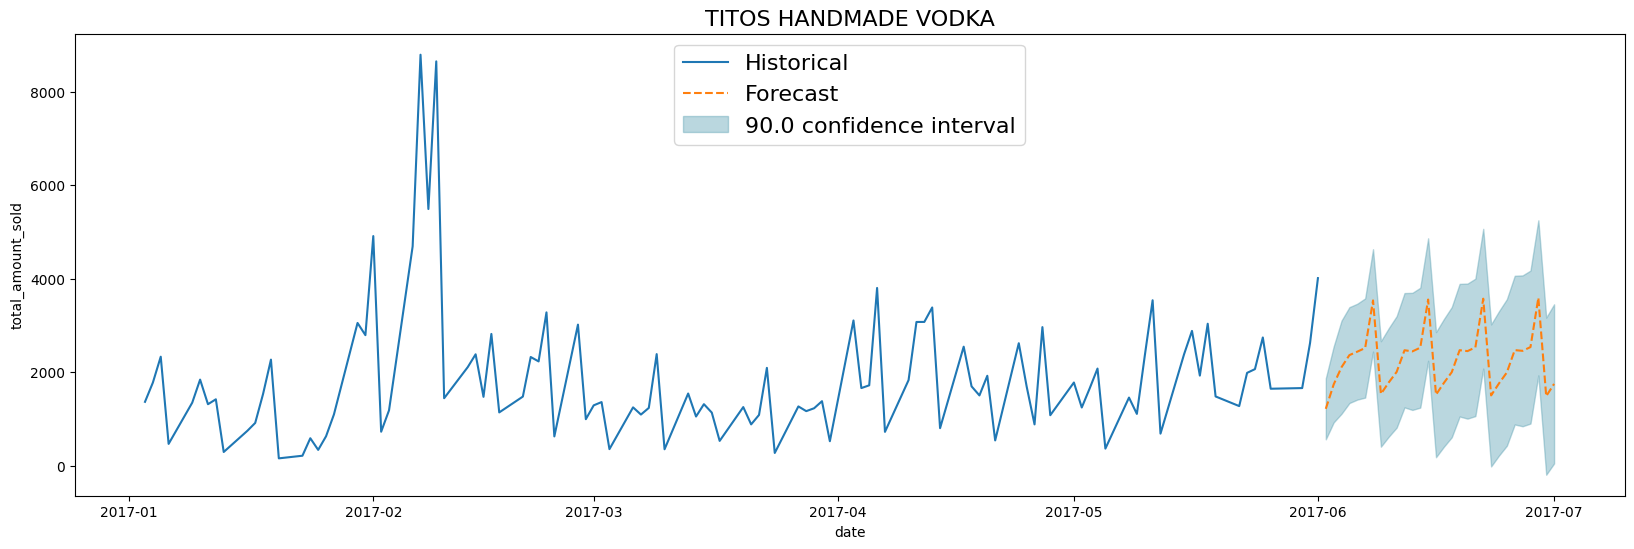

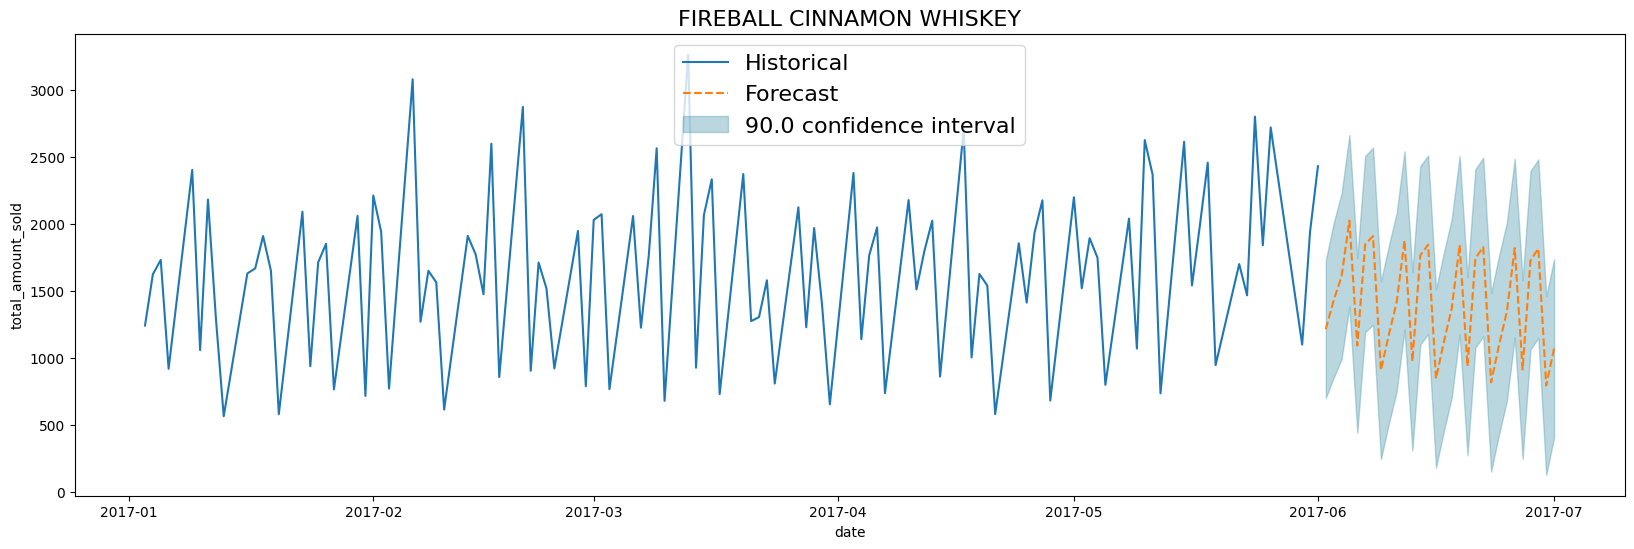

In [34]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item].copy()
    dataf = dfforecast[dfforecast.item_name==item].copy()
    
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = dataf, 
                                 actual = None,
                                 title = item,
                                 plotstartdate = "2017-01-01")

#### Plot the forecasted predictions against the actual data

Save the actual sales data to the `dfactual` Pandas dataframe:

In [35]:
%%bigquery dfactual --params $ARIMA_PARAMS --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast

SELECT 
    date,
    item_description AS item_name,
    SUM(bottles_sold) AS total_amount_sold
FROM
    `bigquery-public-data.iowa_liquor_sales.sales` 
GROUP BY
    date, item_name
HAVING 
    date BETWEEN DATE_ADD(@TRAININGDATA_ENDDATE, 
                              INTERVAL 1 DAY) 
            AND DATE_ADD(@TRAININGDATA_ENDDATE, 
                             INTERVAL 1+CAST(HORIZON AS INT64) DAY) 
ORDER BY
    date;

Query is running:   0%|          |

Downloading:   0%|          |

In [36]:
dfactual.head()

,date,item_name,total_amount_sold
0,2017-06-02,CANADIAN LTD WHISKY,442
1,2017-06-02,TITOS HANDMADE VODKA,658
2,2017-06-02,SOUTHERN COMFORT,508
3,2017-06-02,CROWN ROYAL,346
4,2017-06-02,TOOTERS ALA BAMA SLAMA,16


Plot the forecasted predictions against the training data and actual values, using the `dfhistorical` dataframe that contains the historical data, the `dfforecast` dataframe that contains the prediction data, and the `dfactual` dataframe that contains the actual sales data:

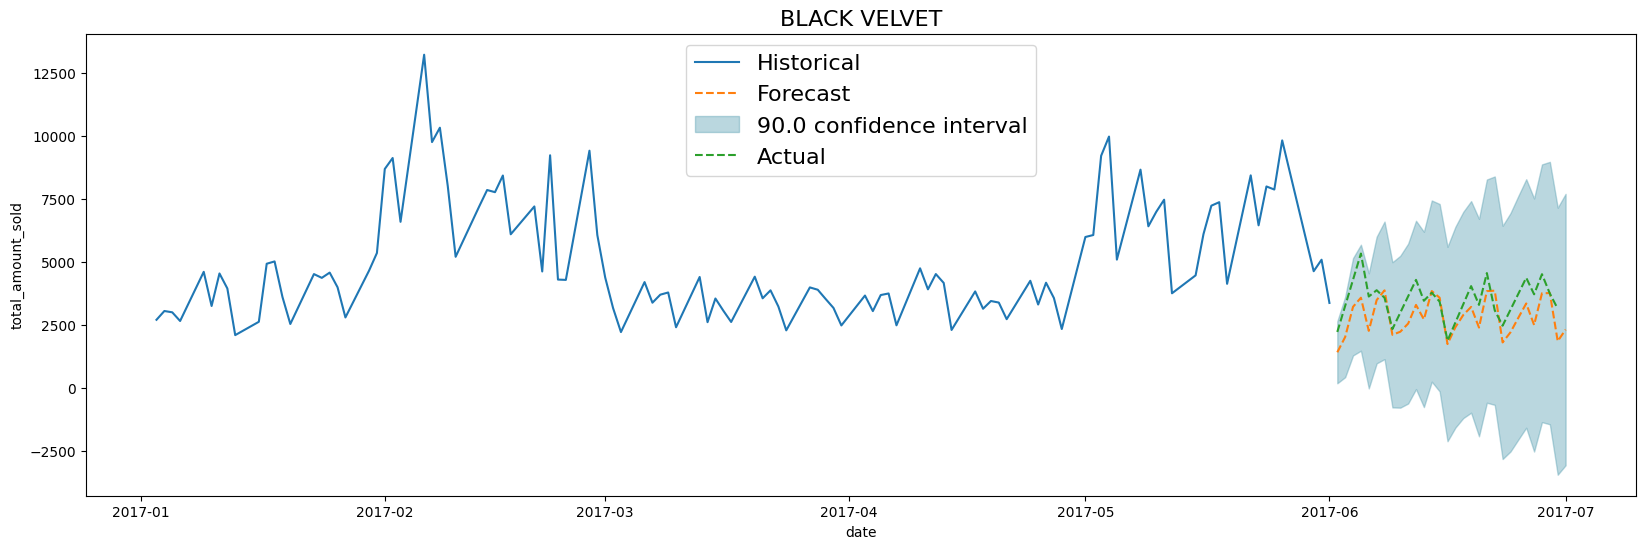

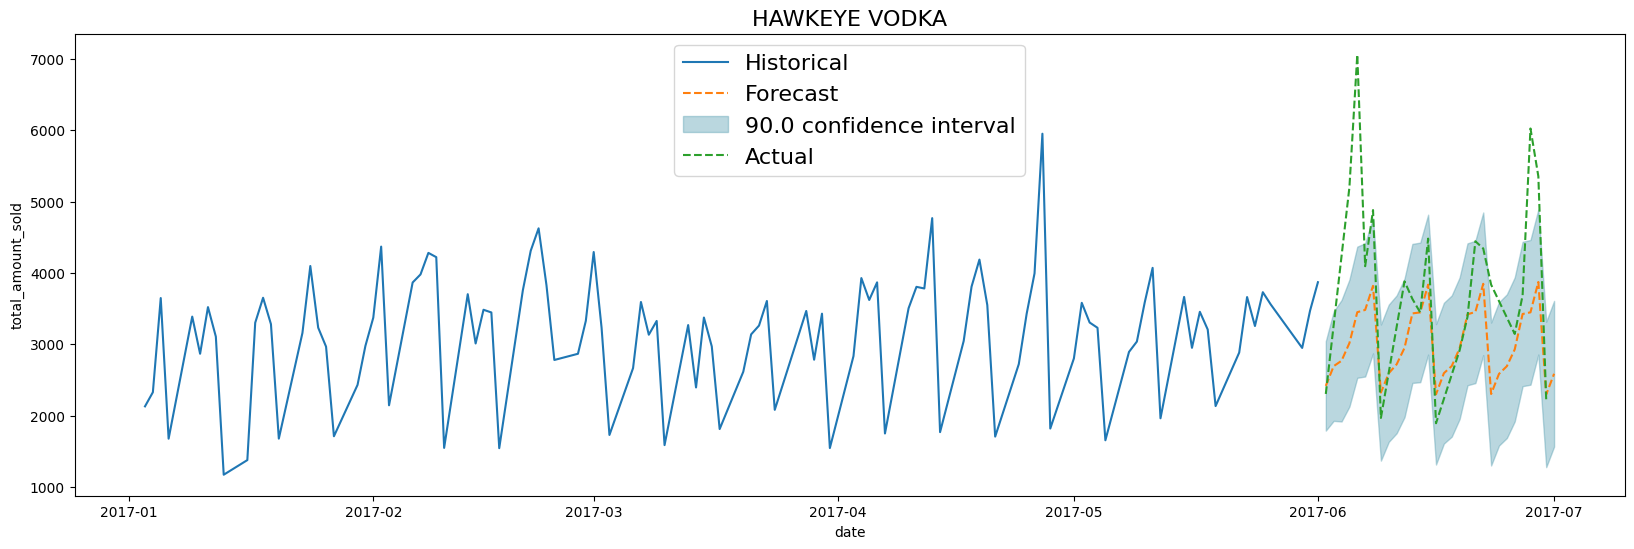

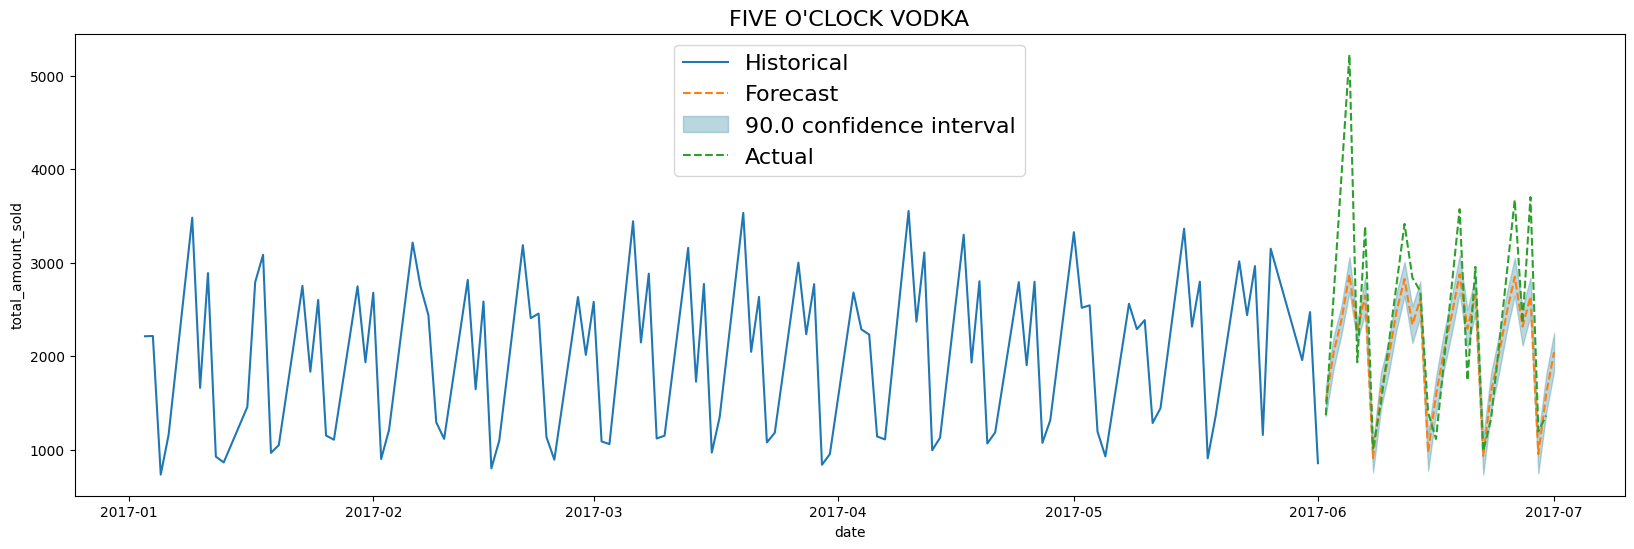

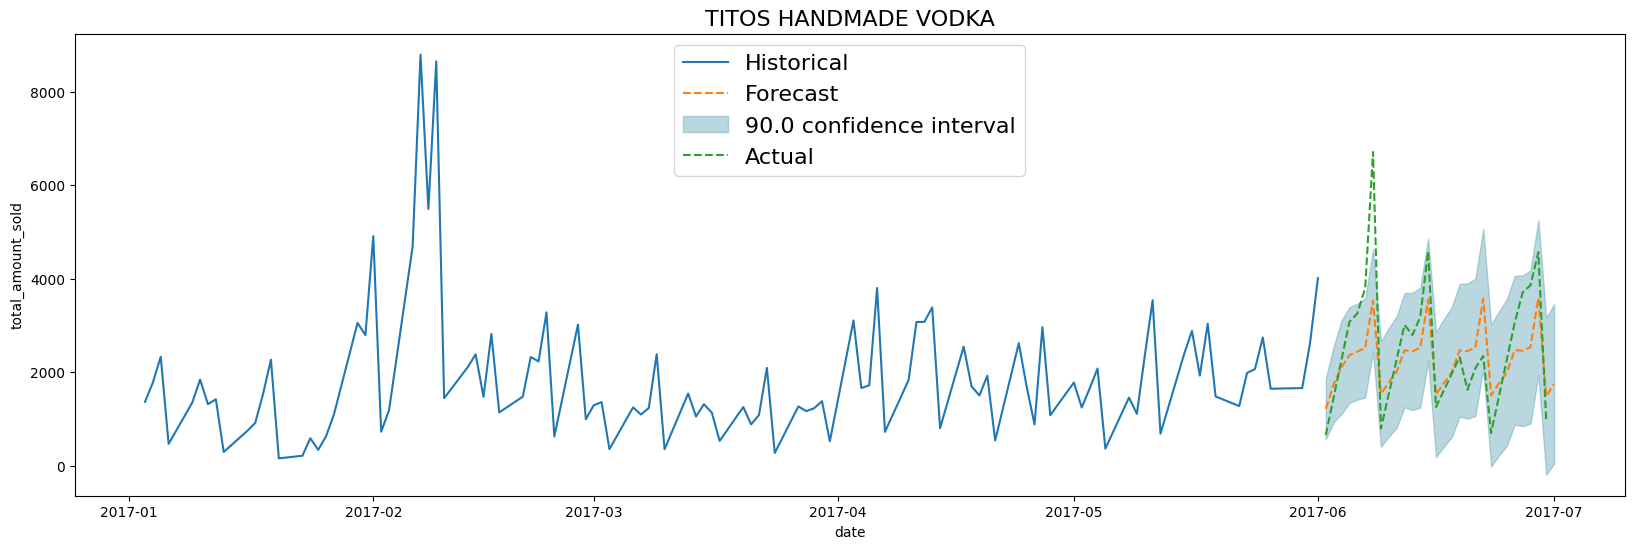

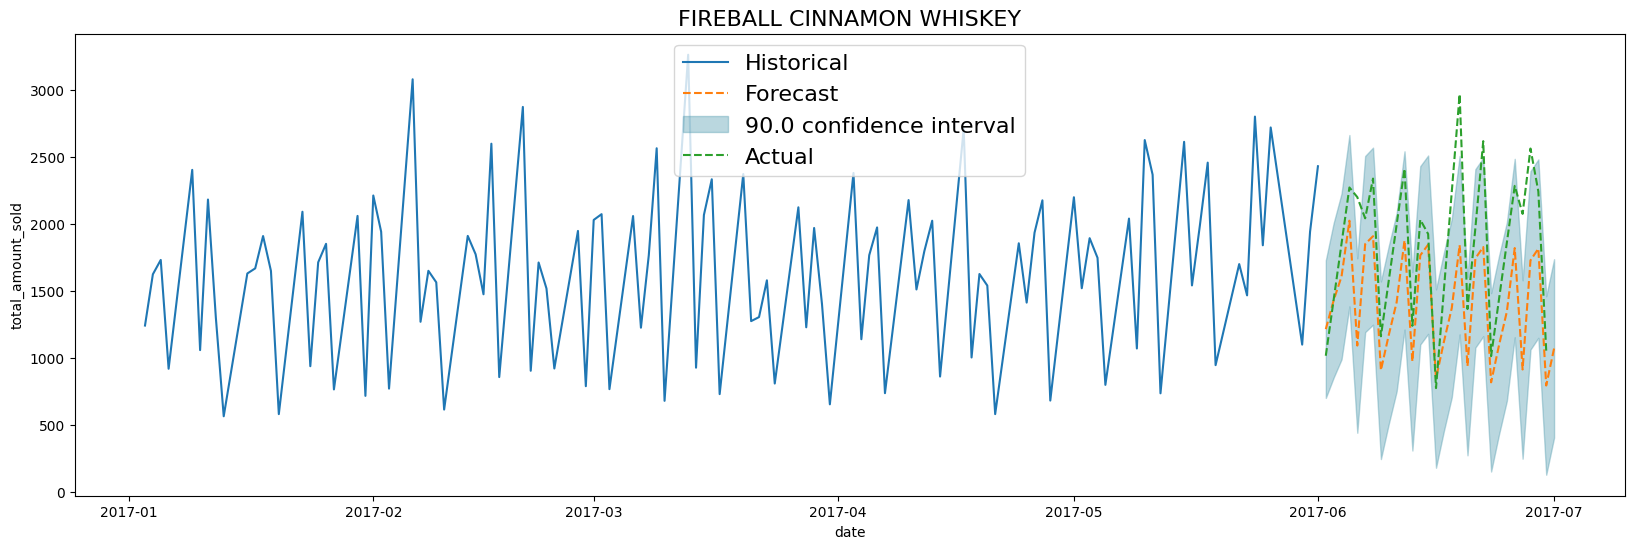

In [37]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item].sort_values('date')
    dataf = dfforecast[dfforecast.item_name==item].sort_values(['forecast_timestamp'])
    dataa = dfactual[dfactual.item_name==item].sort_values('date')
    plot_historical_and_forecast(input_timeseries = datah, 
                             timestamp_col_name = "date", 
                             data_col_name = "total_amount_sold", 
                             forecast_output = dataf, 
                             actual = dataa,
                             title = item,
                             plotstartdate = "2017-01-01")

## Create a dashboard with Data Studio

Follow the steps in this section to create an interactive, shareable dashboard of the forecasted data by using Data Studio. 

### Create a view containing the data for the dashboard

Create a view that concatenates the historical and forecasted data. The SQL before the `UNION ALL` clause selects the historical data. The SQL after the `UNION ALL` clause uses `ML.FORECAST` to generate the forecasted value and the prediction interval. The query uses different fields for `history_value` and `forecasted_value` so that you can plot them in different colors in a following step.

In [ ]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlforecast.outputdata_datastudio AS (
  SELECT
    date AS timestamp,
    item_name,
    total_amount_sold AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
    bqmlforecast.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    item_name,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL bqmlforecast.arima_model,
      STRUCT(30 AS horizon, 0.9 AS confidence_level)) 
  ORDER BY timestamp
  )

""


### Export the data to DataStudio

1. In the **Resources** pane of the [BigQuery console](https://console.cloud.google.com/bigquery), navigate to the `bqmlforecast.outputdata_datastudio` view and select it.
1. Click **Export** and then select **Explore with Data Studio**. A new tab opens in the browser.

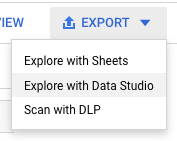


### Set the chart type

In the **Chart** pane, find the **Time series chart** icon and click it, as shown in the following screenshot:

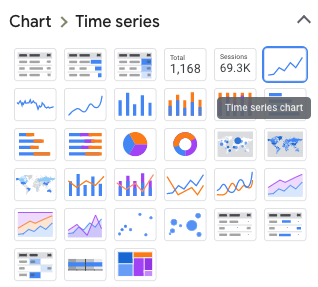

### Set the dashboard data

1. On the **Data** tab, find the **Metric** section.
1. Click **Add metric** to add the `history_value` field.
1. Repeat step 2 to add the `forecast_value`, `prediction_interval_lower_bound` and `prediction_interval_upper_bound` fields.

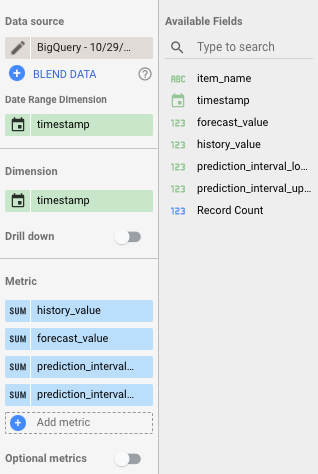

### Set the dashboard style

1. On the **Style** tab, scroll down to the **General** section.
1. For the **Missing Data** option, choose **Linear Interpolation**.

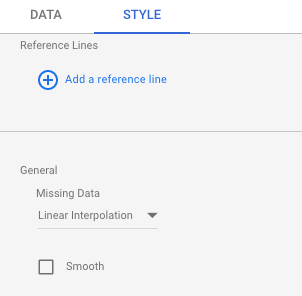

### Set the dashboard filter

1. In the **Filter** pane, click **Drop metric or dimension fields here to create filters** and choose `item_name`.
1. Click `item_name` to see a list of values to filter by.
1. Select **Five O'clock Vodka** to inspect the time series data for just that product.

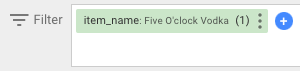

### Review the dashboard

After you complete these steps, the following plot appears in the left panel. The input history time series is in blue, while the forecasted series is in green. The prediction interval is the region between the lower bound series and the upper bound series.

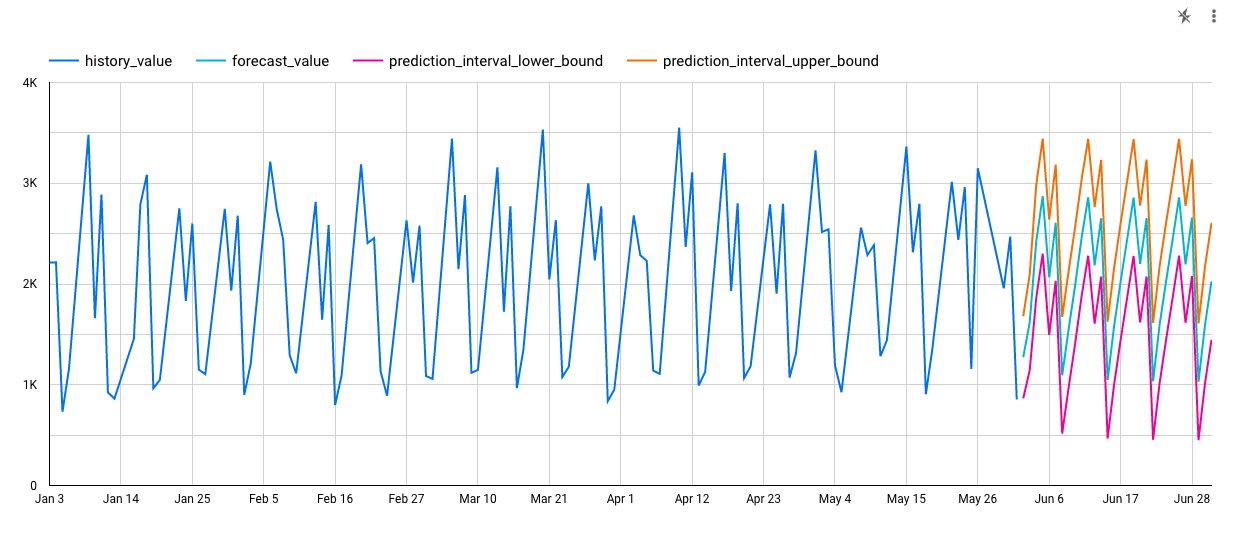